In [18]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
import pandas_datareader as web
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")

# Read sentiment result for StepN and News

In [68]:
news = pd.read_csv(r"data/News_sentiment.csv", sep="\t")
stepn_announcement = pd.read_csv(r"data/STEPN_Announcement_sentiment.csv", sep="\t")
stepn_general = pd.read_csv(r"data/STEPN_General_sentiment.csv", sep="\t")

# Group sentiment score to daily (average)

In [27]:
def match_date(start, end, data):
    data.date = pd.to_datetime(data.date)
    data = data[(data['date'] >= start) & (data['date'] <= end)]
    data["date"] = data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
    #data.columns = data.columns.str.replace('Date', 'date')
    return data

In [28]:
def sentiment_groupby_day(data):
    data.drop(columns=data.columns[0], axis=1, inplace=True)
    data.drop(columns=data.columns[0], axis=1, inplace=True)
    data.drop(columns=data.columns[1], axis=1, inplace=True)
    data = data.groupby(['date'])['sentiment_score'].mean().reset_index().rename(columns={'mean':'sentiment score'})
    data = data.set_index('date') 
    
    data = data.sort_index() # sort by datetime
    return data

In [29]:
def filter_news_sentiment(start, end, data):
    data["date"] = data["date"].apply(lambda x: pd.to_datetime(x, unit="ns", utc=True).floor('D').date())
    crypto_news = data[(data['category'] == 'Cryptocurrencies')].reset_index()
    stocks_market_news = data[(data['category'] == 'Stock Market')].reset_index()
    finance_news = data[(data['category'] == 'Finance')].reset_index()
    #metaverse_news = data[(data['category'] == 'Metaverse')].reset_index()
    
    crypto_news = split_news_category(crypto_news)
    stocks_market_news = split_news_category(stocks_market_news)
    finance_news = split_news_category(finance_news)
    #metaverse_news = split_news_category(metaverse_news, remove_pos_bias, remove_neg_bias)
    
    return crypto_news,stocks_market_news,finance_news

In [36]:
def split_news_category(data):
    #group daily sentiment score
    data = data.drop(['content'], axis=1)
    data = data.groupby(['date'])['sentiment_score'].mean().reset_index().rename(columns={'mean':'sentiment score'})
    data = data.set_index('date') 
    data = data.sort_index() # sort by datetime
    data = data.reset_index()
    
    data = data.set_index('date')
    return data

In [31]:
start = dt.datetime(2022,3,9)
end = dt.datetime(2022,4,25)

In [32]:
crpto_news, stocks_market_news, finance_news = filter_news_sentiment(start, end, news)

In [33]:
stepn_announcement_by_day = sentiment_groupby_day(match_date(start, end, stepn_announcement))
stepn_general_by_day = sentiment_groupby_day(match_date(start, end, stepn_general))

In [20]:
GST = web.DataReader('GST2-USD','yahoo', start, end)
GMT = web.DataReader('GMT3-USD','yahoo', start, end)
GST = GST.reset_index()
GMT = GMT.reset_index()
GST.columns = GST.columns.str.replace('Date', 'date')
GMT.columns = GMT.columns.str.replace('Date', 'date')
GST = match_date(start, end, GST)
GMT = match_date(start, end, GMT)

#add pct change column
ClosingPrice = GST[['Adj Close']]
GST['pct_change'] = ClosingPrice.pct_change()*100
#add pct change column
ClosingPrice = GMT[['Adj Close']]
GMT['pct_change'] = ClosingPrice.pct_change()*100

GST = GST.set_index('date')
GMT = GMT.set_index('date')

In [11]:
def plot_pricing_compare_sentiment(GST_CryptoNews, GST_StocksNews, GST_FinanceNews, GST_StepNAnnoncement, GST_StepNGeneral,
                                  GMT_CryptoNews,GMT_StocksNews,GMT_FinanceNews,GMT_StepNAnnoncement,GMT_StepNGeneral):
    # create figure and axis objects with subplots()
    GST_CryptoNews.reset_index()
    GST_StocksNews.reset_index()
    GST_FinanceNews.reset_index()
    GST_StepNAnnoncement.reset_index()
    GST_StepNGeneral.reset_index()
    
    fig,ax = plt.subplots(5,2,figsize=(20,45))
    plt.subplots_adjust(hspace = 0.25)
    
    # first plot crypto news vs price change
    plot_xy(ax,0,0,GST_CryptoNews,"GST price change vs Crypto News")
    
    # Second plot crypto news vs price change
    plot_xy(ax,1,0,GST_StocksNews,"GST price change vs Stock Market News")
    
    # Third plot crypto news vs price change
    plot_xy(ax,2,0,GST_FinanceNews,"GST price change vs Finance News")
    
    # Forth plot crypto news vs price change
    plot_xy(ax,3,0,GST_StepNAnnoncement,"GST price change vs StepN Announcement")
    
    # Firth plot crypto news vs price change
    plot_xy(ax,4,0,GST_StepNGeneral,"GST price change vs StepN General Discussion")
    
    #####################################################################################
     # first plot crypto news vs price change
    plot_xy(ax,0,1,GMT_CryptoNews,"GMT price change vs Crypto News")
    
    # Second plot crypto news vs price change
    plot_xy(ax,1,1,GMT_StocksNews,"GMT price change vs Stock Market News")
    
    # Third plot crypto news vs price change
    plot_xy(ax,2,1,GMT_FinanceNews,"GMT price change vs Finance News")
    
    # Forth plot crypto news vs price change
    plot_xy(ax,3,1,GMT_StepNAnnoncement,"GMT price change vs StepN Announcement")
    
    # Firth plot crypto news vs price change
    plot_xy(ax,4,1,GMT_StepNGeneral,"GMT price change vs StepN General Discussion")

    plt.show()


In [12]:
def plot_xy(ax,x,y, data, title):
    # first plot crypto news vs price change
    ax[x,y].plot(data.index, data['sentiment_score'], color="red", marker="o")
    # set x-axis label
    ax[x,y].set_xlabel("Date",fontsize=14)
    #ax[x,y].set_xticklabels(data.index, rotation=45)
    # set y-axis label
    ax[x,y].set_ylabel("Sentiment score",color="red",fontsize=14)
    ax[x,y].set_title(title, fontsize=14)
    # twin object for two different y-axis on the sample plot
    ax2=ax[x,y].twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(data.index, data['pct_change'],color="blue",marker="o")
    ax2.set_ylabel("Daily Percentage Change of Adjusted Price",color="blue",fontsize=14)

In [13]:
def sentiment_price_corr(data):
    # Compute the correlation matrix
    # plotting correlation heatmap
    dataplot = sns.heatmap(data.corr(), annot=True,linewidths=.5)

In [14]:
GST_CryptoNews = GST.join(crpto_news)
GST_StocksNews = GST.join(stocks_market_news)
GST_FinanceNews = GST.join(finance_news)
GST_StepNAnnoncement = GST.join(stepn_announcement_by_day)
GST_StepNGeneral = GST.join(stepn_general_by_day)

In [15]:
GMT_CryptoNews = GMT.join(crpto_news)
GMT_StocksNews = GMT.join(stocks_market_news)
GMT_FinanceNews = GMT.join(finance_news)
GMT_StepNAnnoncement = GMT.join(stepn_announcement_by_day)
GMT_StepNGeneral = GMT.join(stepn_general_by_day)

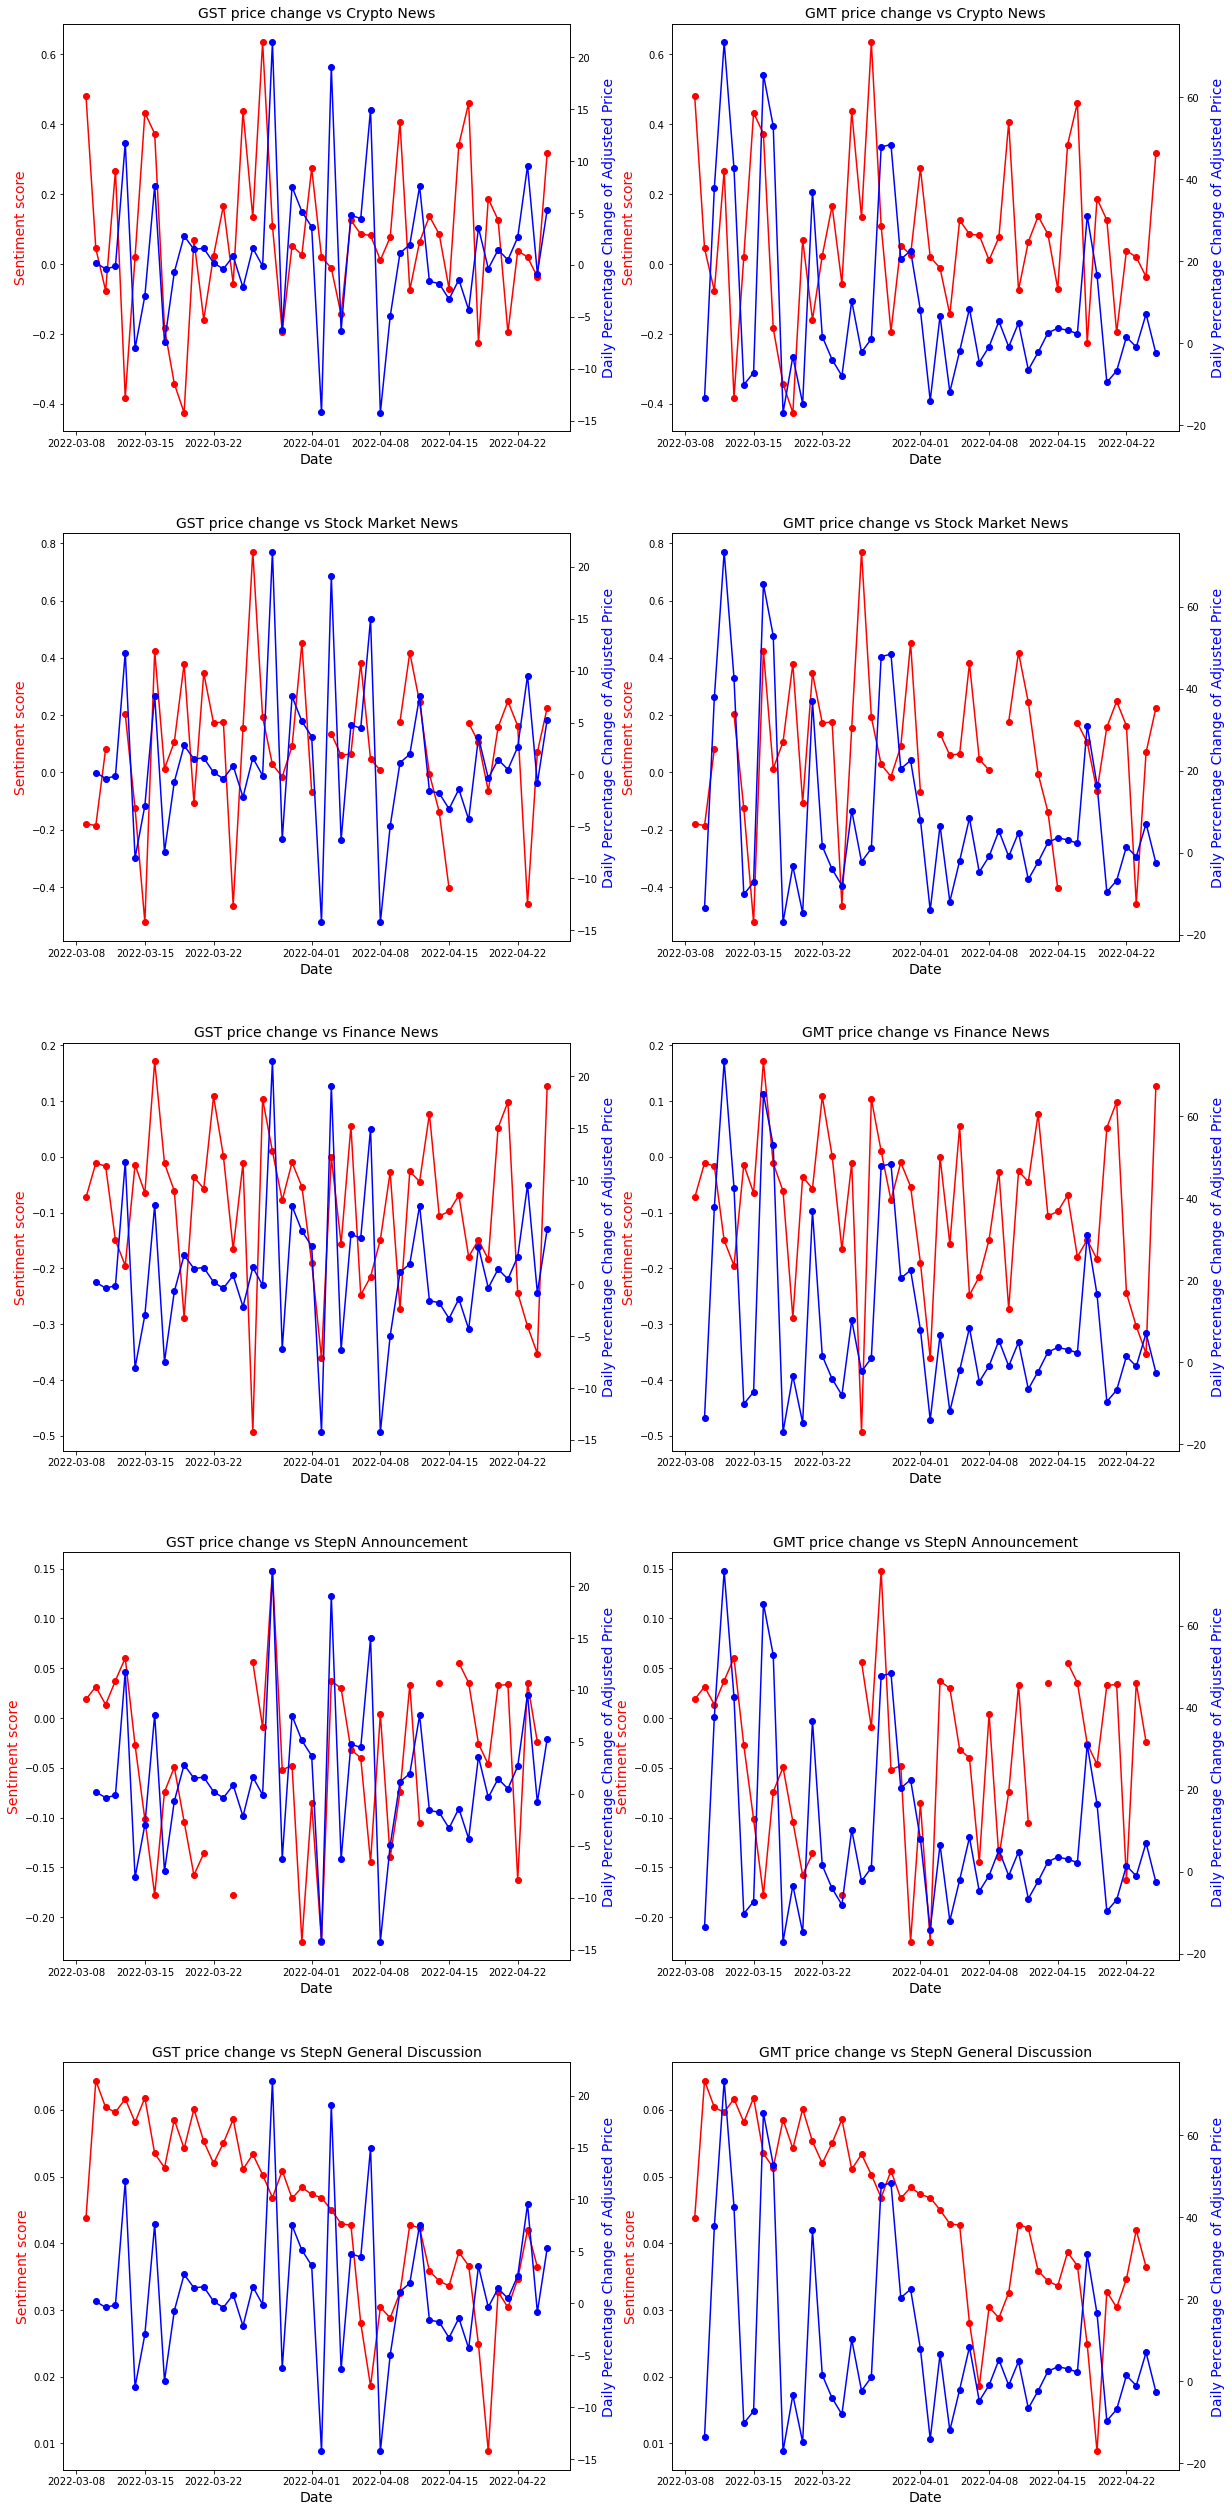

In [16]:
plot_pricing_compare_sentiment(GST_CryptoNews, GST_StocksNews, GST_FinanceNews, GST_StepNAnnoncement, GST_StepNGeneral,
                              GMT_CryptoNews,GMT_StocksNews,GMT_FinanceNews,GMT_StepNAnnoncement,GMT_StepNGeneral)

# Explore high sentiment score to understand what the topic discuss

In [69]:
news.date = pd.to_datetime(news.date)
news = news.set_index('date')

In [70]:
Move_Than_4_crypto_news = crpto_news[crpto_news['sentiment_score'] > 0.4]
Move_Than_4_crypto_news.columns = Move_Than_4_crypto_news.columns.str.replace('sentiment_score', 'avg_sentiment_score')

In [71]:
Move_Than_4_crypto_news = Move_Than_4_crypto_news.join(news)
Move_Than_4_crypto_news.drop(columns=Move_Than_4_crypto_news.columns[0], axis=1, inplace=True)
Move_Than_4_crypto_news.drop(columns=Move_Than_4_crypto_news.columns[0], axis=1, inplace=True)

In [74]:
Move_Than_4_crypto_news = Move_Than_4_crypto_news[Move_Than_4_crypto_news['category']=='Cryptocurrencies']

In [77]:
Move_Than_4_crypto_news

,category,content,sentiment_score
date,,,
2022-03-09,Cryptocurrencies,crypto exchange kraken use russian trading fee...,0.332631
2022-03-09,Cryptocurrencies,next bitcoin prices latest gains bitcoin price...,0.535309
2022-03-09,Cryptocurrencies,leak reveals biden crypto plans sending price ...,0.551113
2022-03-09,Cryptocurrencies,biden crypto executive order puts urgency digi...,0.902484
2022-03-09,Cryptocurrencies,circle crypto future global money crypto poise...,0.072739
2022-03-15,Cryptocurrencies,apple cofounder reveals huge bitcoin price pre...,0.627680
2022-03-15,Cryptocurrencies,ukrainian crypto rainmaker testify senate hear...,0.018839
2022-03-15,Cryptocurrencies,amid new executive order white house director ...,0.016167
2022-03-15,Cryptocurrencies,ethereum software company consensys doubles va...,0.577138


### Merge data for correlation analysis

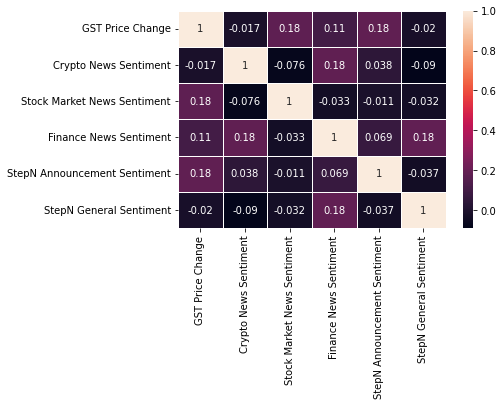

In [19]:
merge_data = pd.DataFrame({ 
                            'GST Price Change' :  GST['pct_change'],
                            'Crypto News Sentiment': crpto_news.sentiment_score,
                            'Stock Market News Sentiment': stocks_market_news.sentiment_score,
                            'Finance News Sentiment': finance_news.sentiment_score,
                            'StepN Announcement Sentiment': stepn_announcement_by_day.sentiment_score,
                            'StepN General Sentiment':stepn_general_by_day.sentiment_score
                          })
sentiment_price_corr(merge_data)

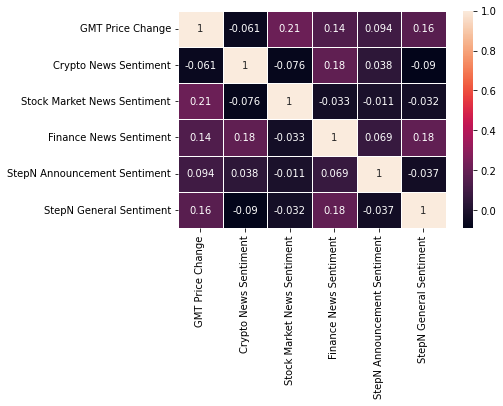

In [26]:
merge_data = pd.DataFrame({ 
                            'GMT Price Change' :  GMT['pct_change'],
                            'Crypto News Sentiment': crpto_news.sentiment_score,
                            'Stock Market News Sentiment': stocks_market_news.sentiment_score,
                            'Finance News Sentiment': finance_news.sentiment_score,
                            'StepN Announcement Sentiment': stepn_announcement_by_day.sentiment_score,
                            'StepN General Sentiment':stepn_general_by_day.sentiment_score
                          })
sentiment_price_corr(merge_data)